# Thinking: 今天讲解了时间序列预测的两种方式，实际上在数据库内建时间属性后，可以产生时序数据库，请思考什么是时序数据库？为什么时间序列数据成为增长最快的数据类型之一
    时序数据库是基于时间数据而成的一种数据库，以时间为维度，存储有历史数据，比传统数据库更快，更方便查找数据。
    时序数据库更能反映出当前数据的趋势性、季度性、周期性，能够基于历史时间数据对未发生的情况提前做出预测，减少事故损失。

# Action: PM2.5数据集预测未来北京PM2.5的值

## 1.加载数据

In [1]:
from datetime import datetime
import pandas as pd
# 数据加载
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('./raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,43820,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,43821,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,43822,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [2]:
# 删掉NO这列
dataset.drop('No', axis=1, inplace=True)

In [3]:
# 列名替换
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# 缺失值填充
dataset['pollution'].fillna(0, inplace=True)
# 去掉第一天数据（前24小时）
dataset = dataset[24:]
dataset.to_csv('pollution.csv')

In [4]:
data = pd.read_csv('pollution.csv',index_col=0)
data

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [5]:
data['pollution'].values

array([129., 148., 159., ...,  10.,   8.,  12.])

## 2.数据可视化

In [6]:
# 可视化数据
import matplotlib.pyplot as plt
%matplotlib inline

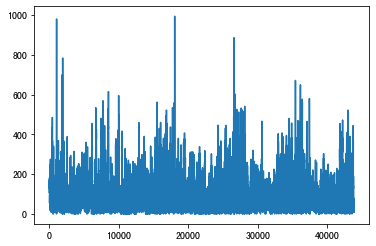

In [7]:
plt.plot(data['pollution'].values)

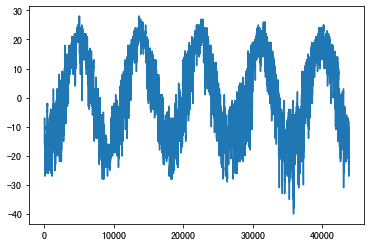

In [8]:
plt.plot(data['dew'].values)

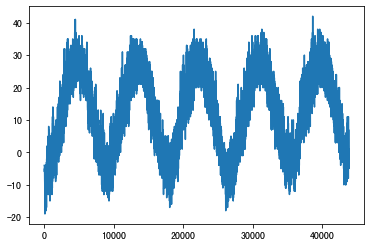

In [9]:
plt.plot(data['temp'].values)

(array([15290.,     0.,     0.,  9384.,     0.,     0., 14130.,     0.,
            0.,  4996.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

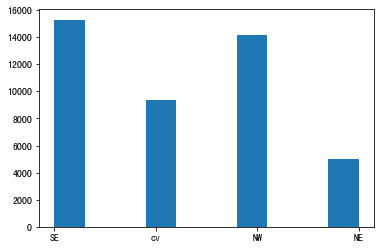

In [10]:
plt.hist(data['wnd_dir'].values)

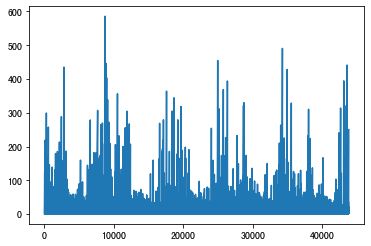

In [11]:
plt.plot(data['wnd_spd'].values)

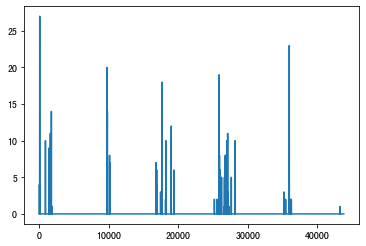

In [12]:
plt.plot(data['snow'].values)

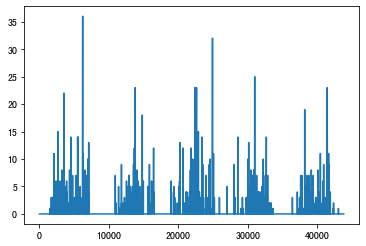

In [13]:
plt.plot(data['rain'].values)

In [14]:
# 将时间序列数据转换为适合监督学习的数据
"""
data：序列，列表或二维的NumPy数组。 必需的参数。
n_in：作为输入步长（X）。 值可能介于[1..len（data）]，可选参数。 默认为1。
n_out：作为输出步长（y）。 值可以在[0..len（data）-1]之间， 可选参数。 默认为1。
dropnan：Boolean是否删除具有NaN值的行。 可选参数。 默认为True。
"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # i: n_in, n_in-1, ..., 1
    # 代表t-n_in, ... ,t-1
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [57]:
# 对wnd_dir 这列进行labelencoder标签编码
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
data['wnd_dir'] = LabelEncoder().fit_transform(data['wnd_dir'])
values = data.values
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]])

In [72]:
# 对数据进行无量纲化，统一数据区间
# minmax = MinMaxScaler()
# scaled = minmax.fit_transform(values)
# scaled

array([[0.12977867, 0.35294118, 0.24590164, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764706, 0.24590164, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995976, 0.42647059, 0.2295082 , ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.26470588, 0.26229508, ..., 0.41399641, 0.        ,
        0.        ],
       [0.00804829, 0.26470588, 0.24590164, ..., 0.42086644, 0.        ,
        0.        ],
       [0.01207243, 0.27941176, 0.26229508, ..., 0.4262155 , 0.        ,
        0.        ]])

In [75]:
reframed = series_to_supervised(values, 1, 1)
# 保存到本地
reframed.to_csv('reframed-1.csv')
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0
2,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0
3,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0
4,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0
5,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,10.0,-22.0,-2.0,1033.0,1.0,226.16,0.0,0.0,8.0,-23.0,-2.0,1034.0,1.0,231.97,0.0,0.0
43796,8.0,-23.0,-2.0,1034.0,1.0,231.97,0.0,0.0,10.0,-22.0,-3.0,1034.0,1.0,237.78,0.0,0.0
43797,10.0,-22.0,-3.0,1034.0,1.0,237.78,0.0,0.0,10.0,-22.0,-3.0,1034.0,1.0,242.70,0.0,0.0
43798,10.0,-22.0,-3.0,1034.0,1.0,242.70,0.0,0.0,8.0,-22.0,-4.0,1034.0,1.0,246.72,0.0,0.0


In [76]:
# 去掉不需要预测的列，即var2(t) var3(t) var4(t) var5(t) var6(t) var7(t) var8(t)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
reframed.to_csv('reframed-2.csv')

In [77]:
# 数据集划分 8/2，时序数据不能用train_test_split
n = int(len(values)*0.8)
train = values[:n,:]
test = values[n:,:]

train_x ,train_y =  train[:,:-1],train[:,-1]
test_x , test_y = test[:,:-1],test[:,-1]

In [78]:
# 将数据转换为3D格式:[样本数，时间步长，特征数]
train_x = train_x.reshape((train_x.shape[0],1,train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0],1,test_x.shape[1]))

In [79]:
train_x.shape,test_x.shape

((35040, 1, 7), (8760, 1, 7))

## 3.使用LSTM进行建模预测

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM , Dense

# 建模
model = Sequential()
model.add(LSTM(50 , input_shape=(train_x.shape[1],train_x.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam' ,loss='mse')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50)                11600     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________


In [81]:
# 模型训练
result = model.fit(train_x ,train_y ,epochs=20 ,batch_size=64 ,validation_data=(test_x,test_y) ,verbose=2 ,shuffle=False)

Epoch 1/20
548/548 - 20s - loss: 2.2124 - val_loss: 1.1448
Epoch 2/20
548/548 - 26s - loss: 2.2201 - val_loss: 1.1397
Epoch 3/20
548/548 - 18s - loss: 2.2197 - val_loss: 1.1382
Epoch 4/20
548/548 - 24s - loss: 2.2054 - val_loss: 1.1388
Epoch 5/20
548/548 - 27s - loss: 2.2036 - val_loss: 1.1322
Epoch 6/20
548/548 - 19s - loss: 2.1987 - val_loss: 1.1312
Epoch 7/20
548/548 - 27s - loss: 2.2040 - val_loss: 1.1356
Epoch 8/20
548/548 - 21s - loss: 2.2030 - val_loss: 1.1451
Epoch 9/20
548/548 - 20s - loss: 2.2107 - val_loss: 1.1280
Epoch 10/20
548/548 - 21s - loss: 2.2000 - val_loss: 1.1450
Epoch 11/20
548/548 - 18s - loss: 2.2033 - val_loss: 1.1273
Epoch 12/20
548/548 - 18s - loss: 2.1958 - val_loss: 1.1304
Epoch 13/20
548/548 - 19s - loss: 2.1913 - val_loss: 1.1332
Epoch 14/20
548/548 - 24s - loss: 2.1822 - val_loss: 1.1266
Epoch 15/20
548/548 - 24s - loss: 2.1819 - val_loss: 1.1265
Epoch 16/20
548/548 - 21s - loss: 2.1703 - val_loss: 1.1254
Epoch 17/20
548/548 - 17s - loss: 2.1690 - val_lo

In [82]:
# 模型预测
train_pre = model.predict(train_x)
test_pre = model.predict(test_x)
train_pre.shape, test_pre.shape

((35040, 1), (8760, 1))

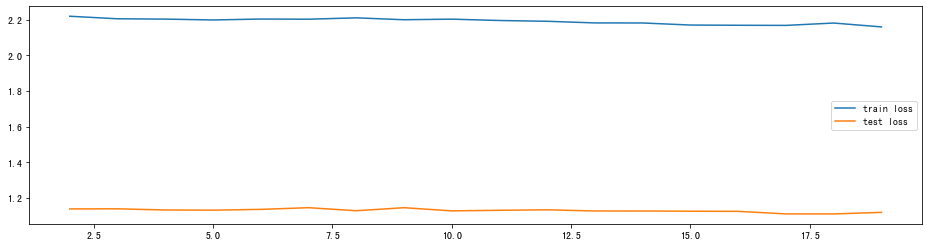

In [83]:
# loss可视化
train_loss = result.history['loss']
val_loss = result.history['val_loss']
plt.figure(figsize=(16, 4))
x = list(range(len(train_loss)))
plt.plot(x[2:], train_loss[2:], label='train loss')
plt.plot(x[2:], val_loss[2:], label='test loss')
plt.legend(loc='best')
plt.show()

In [84]:
# 呈现原始数据，训练结果，预测结果
def plot_img(source_data_set, train_pre, test_pre):

    # 原始数据(蓝色)
    plt.plot(source_data_set[:,-1], label='real',c='b')
    # 训练数据（黄色）
    plt.plot([x for x in train_pre], label='train_predict',c='y')
    # 测试数据(红色)
    plt.plot([None for _ in train_pre]+[x for x in test_pre], label='test_predict' ,c='r')
    plt.legend(loc='best')

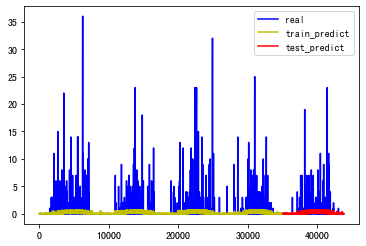

In [85]:
plot_img(values, train_pre ,test_pre)